In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
import matplotlib.pyplot as plt
from torch.autograd import Variable
# 假设配置文件已经定义，并包含了一些基本设置
import config
args = config.args
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d2l.use_svg_display()

# Animator类定义
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None,
                 xscale='linear', yscale='linear', fmts=None, nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        if fmts is None:
            fmts = ['-', 'm--', 'g-.', 'r:']
        plt.ion()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        self.config_axes = lambda: self.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


# 自定义数据集类
class my_dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        # data是从torchvision.datasets中获取的，包含data和targets
        self.point = data.data.type(torch.FloatTensor)  # 将数据转换为浮点张量
        self.label = data.targets.type(torch.FloatTensor)  # 将标签转换为浮点张量
        self.transform = transform

    def __getitem__(self, index):
        x = self.point[index]
        y = self.label[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.label)

# 数据变换
trans = transforms.Compose([
    transforms.ToTensor(),  # 将PIL图像或NumPy ndarray转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化处理
])

# 加载原始FashionMNIST数据集
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

# 使用自定义数据集类创建数据集
train_data = my_dataset(mnist_train)
test_data = my_dataset(mnist_test)

# 创建数据加载器
train_loader = data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=args.batch_size, shuffle=True)

# 定义分类器模型
class Classifier(nn.Module):
    def __init__(self, input_size=784, hidden_layer_size=4, num_classes=10):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 784)  # 展平图像张量为向量
        x = F.relu(self.fc1(x))  # 第一层加ReLU激活
        x = self.fc2(x)  # 输出层
        return x


# 实例化模型并设置到适当的设备上
model = Classifier()
model.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=10, bias=True)
)


RuntimeError: expected scalar type Long but found Float

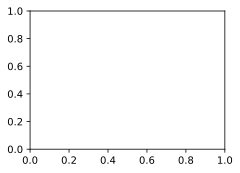

In [11]:
# Initialize the Animator instance for dynamic plotting
animator = Animator(xlabel='epoch', ylabel='loss', legend=['train', 'test'], xlim=[1, args.epochs])

# Lists to store the average losses per epoch for training and testing
train_losses = []
test_losses = []

# Start the training loop
for epoch in range(1, args.epochs + 1):
    model.train()
    train_loss_sum, train_batches = 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = error(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
        train_batches += 1

    # Calculate the average training loss for this epoch
    avg_train_loss = train_loss_sum / train_batches
    train_losses.append(avg_train_loss)

    # Evaluate the model on the test set
    model.eval()
    test_loss_sum, test_batches = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = error(y_hat, y)
            test_loss_sum += loss.item()
            test_batches += 1

    # Calculate the average test loss for this epoch
    avg_test_loss = test_loss_sum / test_batches
    test_losses.append(avg_test_loss)

    # Update the plot
    animator.add(epoch, (avg_train_loss, avg_test_loss))

# Optionally, you can also print out the final values or plot them using a more static method
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Testing Loss: {test_losses[-1]:.4f}')

plt.ioff()  # Turn off interactive plotting
plt.show()  # To ensure the plot is shown in some environments after the loop ends


In [10]:
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size)

batch = next(iter(demo_loader))
images, labels = batch


count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []



for args.epoch in range(args.epoch):
    for images, labels in train_loader:
        # Transfering 
        #  and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


            

AttributeError: 'Namespace' object has no attribute 'epoch'